In [1]:
import pickle
import numpy as np
np.random.seed(100)
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,RobustScaler
X,y_hr,y_participant,y_activity = pickle.load(open('../data/heart_rate_tabular_data_ppg_dalia.p','rb'))

In [2]:
X = X[:,:,:1].reshape(-1,256,1)
# y_activity = y_parti/cipant

In [3]:
for i in range(X.shape[0]):
    X[i] = MinMaxScaler().fit_transform(X[i])

In [4]:
def get_train_test_val_data(X_hr,y_participant,y_activity):
    all_data = pd.DataFrame({'x':np.arange(X_hr.shape[0]),'y':y_participant,'activity':y_activity})
    train_percentage = .8
    val_percentage = train_percentage+.1
    def split_data(df):
        n = df.shape[0]
        train_index = df['x'].values[:int(n*train_percentage)]
        val_index = df['x'].values[int(n*train_percentage):int(n*val_percentage)]
        test_index = df['x'].values[int(n*val_percentage):]
        return pd.DataFrame({'train':[list(train_index)],'val':[list(val_index)],'test':[list(test_index)]})

    index_df = all_data.groupby(['y','activity'],as_index=False).apply(split_data)

    from functools import reduce
    train_index = np.array(reduce(lambda a,b:a+b,index_df['train'].values))
    val_index = np.array(reduce(lambda a,b:a+b,index_df['val'].values))
    test_index = np.array(reduce(lambda a,b:a+b,index_df['test'].values))


    train_x,train_y = X_hr[train_index],y_participant[train_index]
    val_x,val_y = X_hr[val_index],y_participant[val_index]
    test_x,test_y = X_hr[test_index],y_participant[test_index]
    return train_x,train_y,val_x,val_y,test_x,test_y,train_index,test_index,val_index 

In [5]:
import pandas as pd
window_size = 8
n_timesteps = window_size*32
n_channels = 1
train_x,train_y,val_x,val_y,test_x,test_y,train_index,test_index,val_index  = get_train_test_val_data(X[:,:,:],
                                                                                                      y_participant,
                                                                                                      y_activity)
train_activity = y_activity[train_index]
test_activity = y_activity[test_index]
train_y = y_hr[train_index]
test_y = y_hr[test_index]
val_y = y_hr[val_index]

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[3], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,LeaveOneGroupOut
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split
# import numpy as np
# %matplotlib notebook
from tensorflow.keras.layers import Conv1D,BatchNormalization,Dropout,Input,MaxPooling1D,Flatten,Dense,Input,Reshape
from tensorflow.keras.models import Model, Sequential
def get_model(input_shape=(256,3),act='relu',loss="categorical_crossentropy",opt='adam',
              n_classes=300,n_output = 1):
    
    
    model =  Sequential()
    model.add(Input(shape=input_shape))
    model.add(Reshape(input_shape))
    model.add(Conv1D(100,40,input_shape=input_shape,activation='selu',kernel_initializer='normal',padding='same'))
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
    model.add(Conv1D(50,40,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(100,20,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(100,20,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(100,20,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    
    model.add(Conv1D(100,20,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(200,2,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(BatchNormalization())
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
    model.add(Dropout(.2))
    model.add(Flatten())
#     model.add(Dense(n_classes,activation='relu'))
#     model.add(Dense(n_output*2,activation='relu'))
    model.add(Dense(n_output,activation=None))
#     model.summary()
    input_ = Input(shape=input_shape)
    reshaped_input = Reshape(input_shape)(input_)
    embedding = model(reshaped_input)
#     embedding = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1),name='feature')(embedding)
    
#     embedding = Dense(n_output,activation='relu')(embedding)
    y_output = Dense(n_output,activation='relu',name='output')(embedding) 
    model1 = Model(input_,y_output)
#     model1.compile(loss={'output':tf.keras.losses.SparseCategoricalCrossentropy(),
#                         'feature':tfa.losses.TripletSemiHardLoss()},optimizer=opt,
#                    loss_weights={'output':1,'feature':0})
    model1.compile(loss=tf.keras.losses.MeanSquaredError(),optimizer='adam')
    return model1

model =  get_model(n_classes=len(np.unique(train_y)))
model.summary()
len(np.unique(train_y))

4 Physical GPUs, 1 Logical GPU
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 3)]          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 256, 3)            0         
_________________________________________________________________
sequential (Sequential)      (None, 1)                 956951    
_________________________________________________________________
output (Dense)               (None, 1)                 2         
Total params: 956,953
Trainable params: 955,653
Non-trainable params: 1,300
_________________________________________________________________


20083

In [7]:
from keras.models import load_model
n_output = len(np.unique(train_y))
model = get_model(input_shape=(n_timesteps,n_channels),n_output=1,loss='sparse_categorical_crossentropy',n_classes=300)
model.summary()
filepath = '../model_files/heart_rate_estimator_8_secs_ppg_dalia.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=False)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)
callbacks_list = [es,checkpoint]
history = model.fit(train_x,train_y,validation_data=(val_x,val_y), epochs=100, batch_size=200,verbose=1,
      callbacks=callbacks_list,shuffle=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 1)]          0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 256, 1)            0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 948951    
_________________________________________________________________
output (Dense)               (None, 1)                 2         
Total params: 948,953
Trainable params: 947,653
Non-trainable params: 1,300
_________________________________________________________________
Epoch 1/100
101/101 [==============================] - ETA: 0s - loss: 5040.5498
Epoch 00001: val_loss improved from inf to 3917.33643, saving model to ../model_files/heart_rate_estimator_8_secs_ppg_dalia.hdf5
101/101 [============================

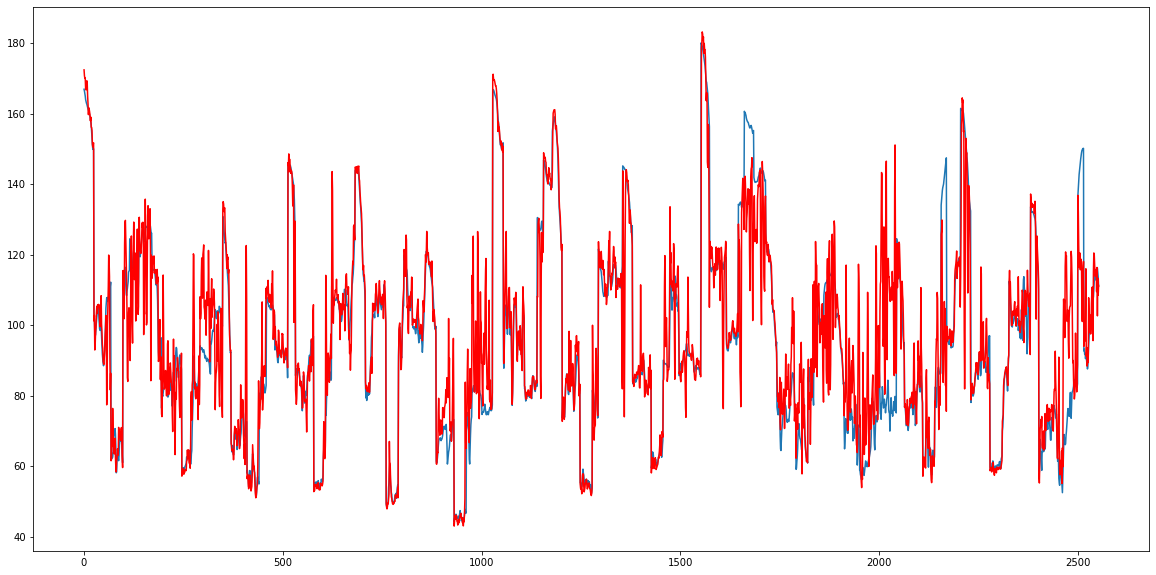

In [10]:
model.load_weights(filepath)
plt.figure(figsize=(20,10))
plt.plot(test_y)
plt.plot(model.predict(test_x),'r')
plt.show()

In [ ]:
fs = 32
hr = 50
window_size = 8
t = np.linspace(0,window_size,window_size*fs)

In [ ]:
plt.plot(t,np.sin((2*np.pi*hr/60)*t))

In [ ]:
plt.plot(t,2*np.sin((2*np.pi*(hr+1)/60)*t)+3*np.sin((2*np.pi*hr/60)*t))

In [6]:
tf.linspace(1, 5, 10)

NotFoundError: Could not find valid device for node.
Node:{{node LinSpace}}
All kernels registered for op LinSpace :
  device='XLA_GPU'; Tidx in [DT_INT32, DT_INT64]; T in [DT_FLOAT, DT_DOUBLE, DT_BFLOAT16, DT_HALF]
  device='XLA_CPU'; Tidx in [DT_INT32, DT_INT64]; T in [DT_FLOAT, DT_DOUBLE, DT_BFLOAT16, DT_HALF]
  device='XLA_CPU_JIT'; Tidx in [DT_INT32, DT_INT64]; T in [DT_FLOAT, DT_DOUBLE, DT_BFLOAT16, DT_HALF]
  device='XLA_GPU_JIT'; Tidx in [DT_INT32, DT_INT64]; T in [DT_FLOAT, DT_DOUBLE, DT_BFLOAT16, DT_HALF]
  device='CPU'; T in [DT_DOUBLE]; Tidx in [DT_INT64]
  device='CPU'; T in [DT_DOUBLE]; Tidx in [DT_INT32]
  device='CPU'; T in [DT_FLOAT]; Tidx in [DT_INT64]
  device='CPU'; T in [DT_FLOAT]; Tidx in [DT_INT32]
  device='GPU'; T in [DT_DOUBLE]; Tidx in [DT_INT64]
  device='GPU'; T in [DT_DOUBLE]; Tidx in [DT_INT32]
  device='GPU'; T in [DT_FLOAT]; Tidx in [DT_INT64]
  device='GPU'; T in [DT_FLOAT]; Tidx in [DT_INT32]
 [Op:LinSpace]

In [4]:
tf.cast(1, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>